In [190]:
#!pip install obspy

In [191]:
import time

# get the start time
st = time.time()

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read Segy

In [193]:
from obspy.io.segy.segy import _read_segy

stream = _read_segy(r'D:\ML\Ahmad codes\XL_5500_Geobody.sgy', headonly=True)

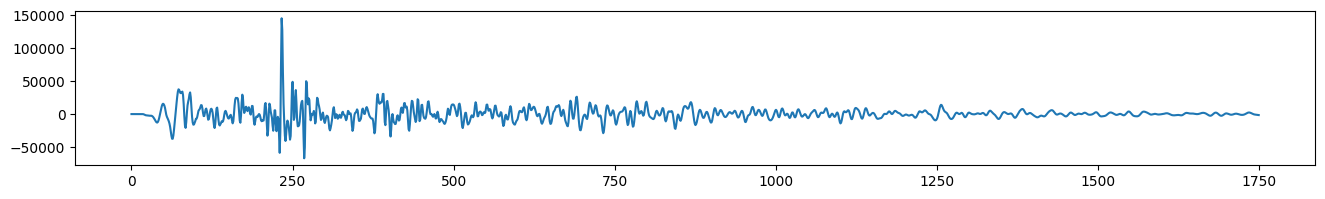

In [194]:
one_trace = stream.traces[500]

plt.figure(figsize=(16,2))
plt.plot(one_trace.data)
plt.show()

In [195]:
data = np.stack(t.data for t in stream.traces)

In [196]:
data.shape  # traces, time samples

(1936, 1750)

In [197]:
vm = np.percentile(data, 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm, data.max()))

The 99th percentile is 33856; the max amplitude is 287744


In [198]:
Seismic_data=data.T

In [199]:
Seismic_data.dtype

dtype('float32')

In [200]:
Seismic_data.shape

(1750, 1936)

In [201]:
Seismic_data=Seismic_data[1:1200,50:1780]

# Display Segy

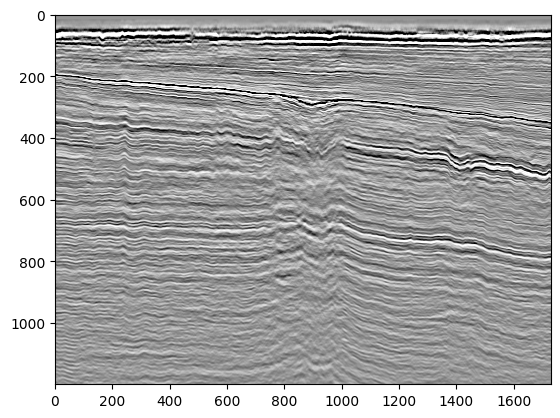

In [202]:
plt.imshow(Seismic_data, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')

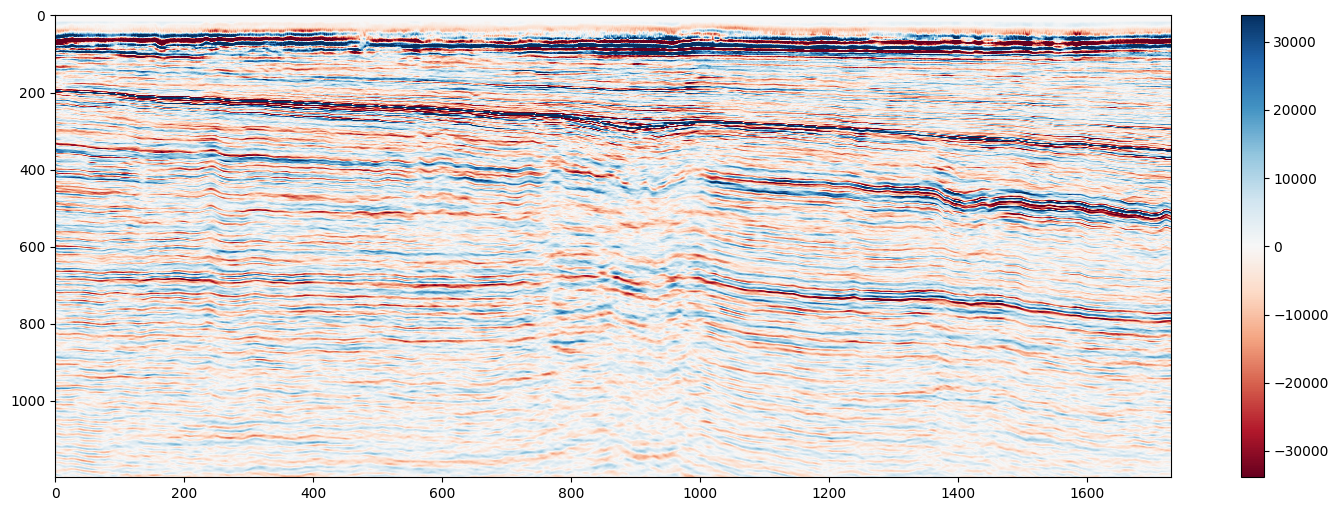

In [203]:
plt.figure(figsize=(18,6))
plt.imshow(Seismic_data, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto')
plt.colorbar()
plt.show()

In [204]:
Seismic_data

array([[    0.   ,     0.   ,     0.   , ...,     0.   ,     0.   ,
            0.   ],
       [    0.   ,     0.   ,     0.   , ...,     0.   ,     0.   ,
            0.   ],
       [    0.   ,     0.   ,     0.   , ...,     0.   ,     0.   ,
            0.   ],
       ...,
       [-1505.   , -1091.   ,  -160.25 , ...,  1074.   ,   896.5  ,
          896.5  ],
       [-3318.   , -3372.   , -2970.   , ...,   918.   ,   874.5  ,
          968.5  ],
       [-3736.   , -4232.   , -4432.   , ...,   136.125,   175.   ,
          257.5  ]], dtype=float32)

In [205]:
from scipy.signal import butter, cheby1, filtfilt
filtered_data=np.zeros((Seismic_data.shape[0], Seismic_data.shape[1]))
dt=0.004
order = 3
Wn = [5,20]  # in Hz
btype = 'bandpass'
fs = 1/dt  # in Hz
b, a = butter(order, Wn, btype, fs = fs)

for i in range(0,Seismic_data.shape[1]-1):
    temp=Seismic_data[:,i]
    data_butter = filtfilt(b, a, temp)
    filtered_data[:,i]=data_butter

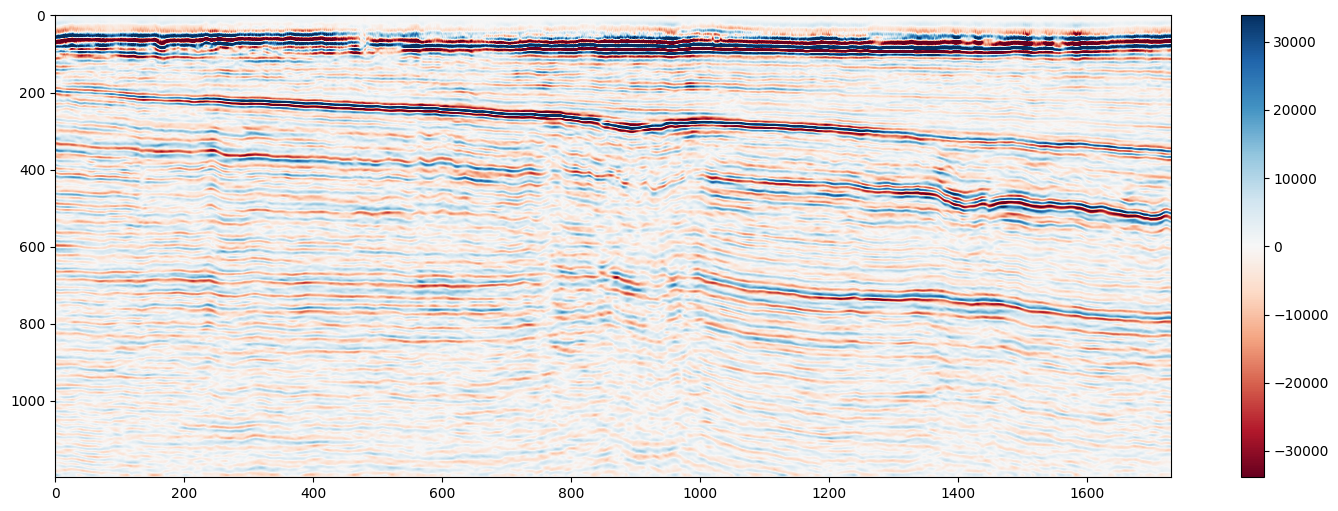

In [206]:
plt.figure(figsize=(18,6))
plt.imshow(filtered_data, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto')
plt.colorbar()
plt.show()

# Applying seismic attributes using Burges Geophysics package

In [207]:
# Pip install burges

In [208]:
# https://code.agilescientific.com/bruges/index.html#

In [209]:
# check null values
Seismic_data_temp=pd.DataFrame(Seismic_data)
Seismic_data_temp.isnull().sum().sum()

0

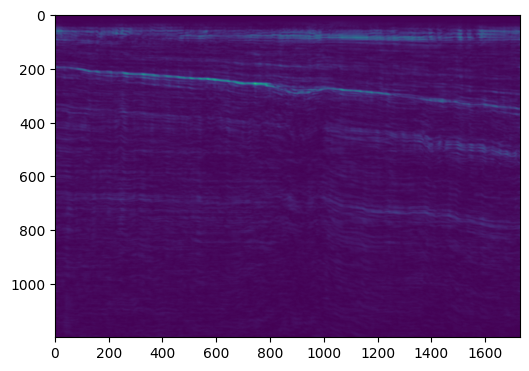

In [210]:
import bruges as bg
env = bg.attribute.envelope(Seismic_data)
plt.figure(figsize=(6, 10))
plt.imshow(env, interpolation='bicubic')

In [211]:
# check null values
env_temp=pd.DataFrame(env)
env_temp.isnull().sum().sum()

0

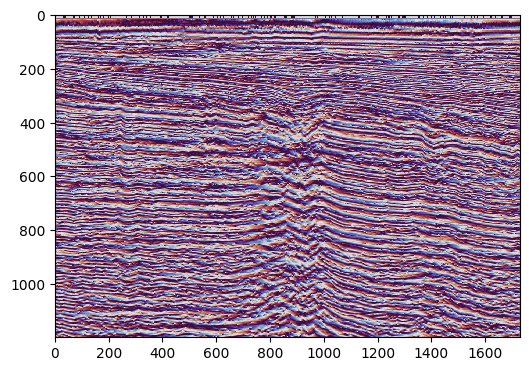

In [212]:
phase = bg.attribute.instantaneous_phase(Seismic_data)
plt.figure(figsize=(6, 10))
plt.imshow(phase, cmap='twilight_shifted', interpolation='none')

In [213]:
# check null values
phase_temp=pd.DataFrame(phase)
phase_temp.isnull().sum().sum()

0

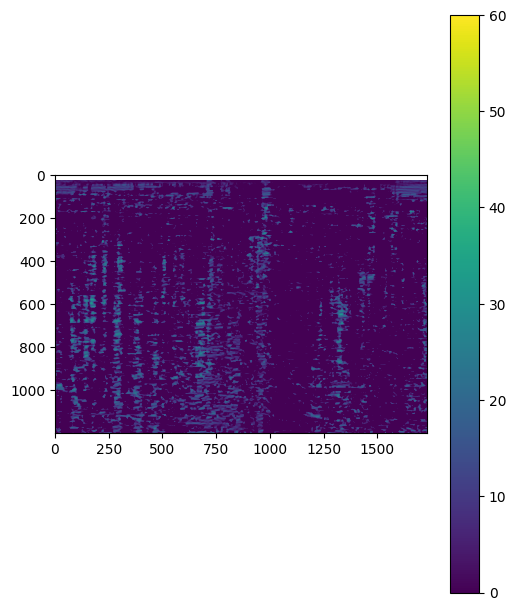

In [214]:
freq = bg.attribute.instantaneous_frequency(Seismic_data, dt=0.004)
plt.figure(figsize=(6, 10))
plt.imshow(freq, interpolation='bicubic', vmin=0,vmax=60)
plt.colorbar(shrink=0.75)

In [215]:
# check null values
freq_temp=pd.DataFrame(freq)
freq_temp.isnull().sum().sum()

22490

In [216]:
freq_temp.fillna(freq_temp.median(),inplace=True)

In [217]:
# check null values
freq_temp=pd.DataFrame(freq)
freq_temp.isnull().sum().sum()

0

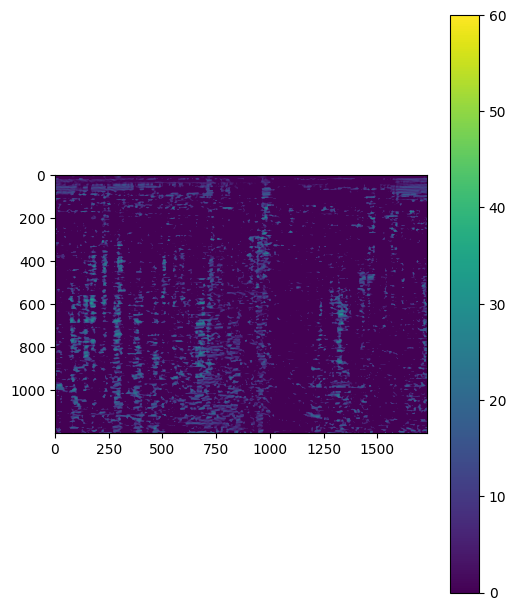

In [218]:
freq2 = freq_temp.values
plt.figure(figsize=(6, 10))
plt.imshow(freq2, interpolation='bicubic', vmin=0,vmax=60)
plt.colorbar(shrink=0.75)

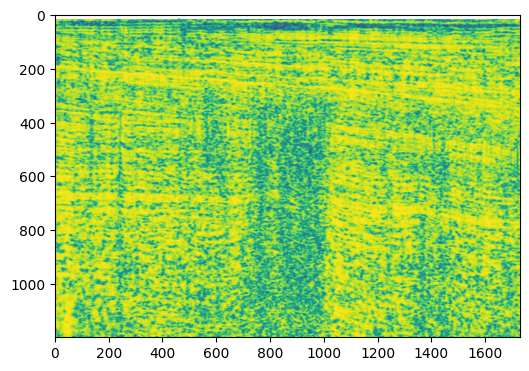

In [219]:
semb = bg.attribute.similarity(Seismic_data, duration=0.036, dt=0.004, kind='gst')
plt.figure(figsize=(6, 10))
plt.imshow(semb, interpolation='bicubic')

In [220]:
# check null values
semb_data_temp=pd.DataFrame(semb)
semb_data_temp.isnull().sum().sum()

20492

In [221]:
semb_data_temp.fillna(semb_data_temp.median(),inplace=True)

In [222]:
# check null values
semb_data_temp.isnull().sum().sum()

0

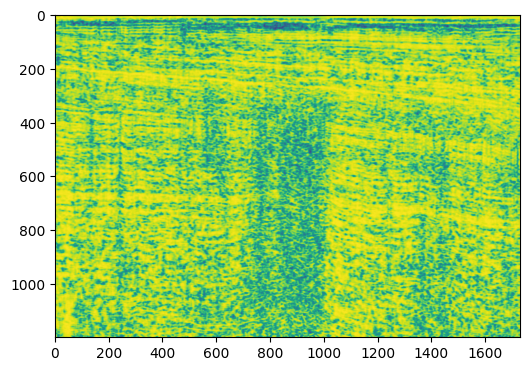

In [223]:
semb2 = semb_data_temp.values
plt.figure(figsize=(6, 10))
plt.imshow(semb2, interpolation='bicubic')

# K-means clustering

In [224]:
from sklearn.cluster import KMeans

In [225]:
Seismic_data.shape

(1199, 1730)

In [226]:
indices = np.where(Seismic_data>-100000000000000000)
index_row, index_col = indices
dist_Seismic_data = Seismic_data[indices]
dist_env = env[indices]
dist_phase_data = phase[indices]
#dist_freq_data = freq2[indices]
dist_semb_data = semb2[indices]

In [227]:
index_row

array([   0,    0,    0, ..., 1198, 1198, 1198], dtype=int64)

In [228]:
index_col

array([   0,    1,    2, ..., 1727, 1728, 1729], dtype=int64)

In [229]:
dist_Seismic_data

array([  0.   ,   0.   ,   0.   , ..., 136.125, 175.   , 257.5  ],
      dtype=float32)

In [230]:
# convert numpy ndarray to dataframe
index_row_DF= pd.DataFrame(index_row, columns = ['index_row'])
index_row_DF.head()

index_row
0          0
1          0
2          0
3          0
4          0

In [231]:
# convert numpy ndarray to dataframe
index_col_DF= pd.DataFrame(index_col, columns = ['index_col'])
index_col_DF.head()

index_col
0          0
1          1
2          2
3          3
4          4

In [232]:
# convert numpy ndarray to dataframe
dist_Seismic_data_DF= pd.DataFrame(dist_Seismic_data, columns = ['dist'])
dist_Seismic_data_DF.head()

dist
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0

In [233]:
# convert numpy ndarray to dataframe
dist_env_DF= pd.DataFrame(dist_env, columns = ['env'])
dist_env_DF.head()

env
0  0.0
1  0.0
2  0.0
3  0.0
4  0.0

In [234]:
# convert numpy ndarray to dataframe
dist_phase_data_DF= pd.DataFrame(dist_phase_data, columns = ['phase'])
dist_phase_data_DF.head()

phase
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0

In [235]:
# convert numpy ndarray to dataframe
dist_semb_data_DF= pd.DataFrame(dist_semb_data, columns = ['semb'])
dist_semb_data_DF.head()

semb
0  0.953898
1  0.947347
2  0.938698
3  0.933310
4  0.926007

In [236]:
# Combining dataframes
# Place the DataFrames side by side
merged_Att = pd.concat([index_row_DF, index_col_DF,dist_Seismic_data_DF,dist_env_DF,dist_phase_data_DF,dist_semb_data_DF], axis=1)
merged_Att.head()

index_row  index_col  dist  env  phase      semb
0          0          0   0.0  0.0    0.0  0.953898
1          0          1   0.0  0.0    0.0  0.947347
2          0          2   0.0  0.0    0.0  0.938698
3          0          3   0.0  0.0    0.0  0.933310
4          0          4   0.0  0.0    0.0  0.926007

In [237]:
dataset_Att=merged_Att.iloc[:,2:].values

In [238]:
dataset_Att

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.53897893e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.47347462e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.38698411e-01],
       ...,
       [1.36125000e+02, 4.38032373e+03, 1.53971457e+00, 8.74996483e-01],
       [1.75000000e+02, 4.09779541e+03, 1.52807760e+00, 8.96049142e-01],
       [2.57500000e+02, 6.45293652e+03, 1.53088152e+00, 8.98956120e-01]])

In [239]:
# apply again K-means with optimum number of classes
kmeans=KMeans(n_clusters=5,init='k-means++',random_state=42)
y_kmeans_classes=kmeans.fit_predict(dataset_Att)

In [240]:
# convert numpy ndarray to dataframe
y_kmeans_classes_DF= pd.DataFrame(y_kmeans_classes, columns = ['kmeans_classes'])
y_kmeans_classes_DF.head()

kmeans_classes
0               0
1               0
2               0
3               0
4               0

In [241]:
merged_Att2 = pd.concat([merged_Att,y_kmeans_classes_DF], axis=1)
merged_Att2.head()

index_row  index_col  dist  env  phase      semb  kmeans_classes
0          0          0   0.0  0.0    0.0  0.953898               0
1          0          1   0.0  0.0    0.0  0.947347               0
2          0          2   0.0  0.0    0.0  0.938698               0
3          0          3   0.0  0.0    0.0  0.933310               0
4          0          4   0.0  0.0    0.0  0.926007               0

In [242]:
merged_Att2['kmeans_classes'].value_counts(normalize=True)*100

0    67.127375
2    17.398651
4    12.644400
3     1.981275
1     0.848298
Name: kmeans_classes, dtype: float64

In [243]:
merged_Att2.shape

(2074270, 7)

In [244]:
kmeans_classes_matrix=np.zeros((Seismic_data.shape[0],Seismic_data.shape[1]))

In [245]:
for iii in range(0,merged_Att2.shape[0]):
    kmeans_classes_matrix[merged_Att2.iloc[iii,0],merged_Att2.iloc[iii,1]]= merged_Att2.iloc[iii,6]

In [246]:
kmeans_classes_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [247]:
print(kmeans_classes_matrix.max())
print(kmeans_classes_matrix.min())

4.0
0.0


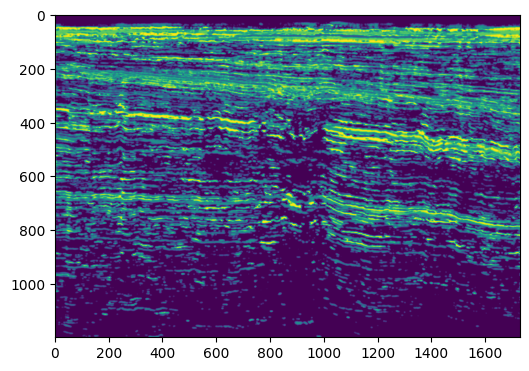

In [248]:
plt.figure(figsize=(6, 10))
plt.imshow(kmeans_classes_matrix, interpolation='bicubic')

In [249]:
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 548.5921583175659 seconds
